<a href="https://colab.research.google.com/github/mohammadgh76/Federated-Learning/blob/main/Finall_FEDPSO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

def balance_classes(x_train, y_train):
    # Define target counts for each class
    target_train = {
        0: 12000,  # attack_normal
        1: 12000,  # attack_Probing
        2: 12000,  # attack_Dos
        3: 12000,  # attack_U2R
        4: 12000   # attack_R2L
    }
    # Undersample majority classes and oversample minority class
    undersampler = RandomUnderSampler(sampling_strategy='auto')
    oversampler = RandomOverSampler(sampling_strategy=target_train)
    # undersampler = RandomUnderSampler(sampling_strategy='auto')
    # oversampler = RandomOverSampler(sampling_strategy=target_counts_test)
    # Undersample majority classes
    x_train_undersampled, y_train_undersampled = undersampler.fit_resample(x_train, y_train)
    # Oversample minority class
    x_train_balanced, y_train_balanced = oversampler.fit_resample(x_train_undersampled, y_train_undersampled)

    return x_train_balanced, y_train_balanced

def balance_classes_test(x_test, y_test):
    # Define target counts for each class
    target_counts_test = {
        0: 2000,  # attack_normal
        1: 2000,  # attack_Probing
        2: 2000,  # attack_Dos
        3: 2000,  # attack_U2R
        4: 2000   # attack_R2L
    }
    # Undersample majority classes and oversample minority class
    undersampler = RandomUnderSampler(sampling_strategy='auto')
    oversampler = RandomOverSampler(sampling_strategy=target_counts_test)

    # Undersample majority classes
    x_test_undersampled, y_test_undersampled = undersampler.fit_resample(x_test, y_test)

    # Oversample minority class
    x_test_balanced, y_test_balanced = oversampler.fit_resample(x_test_undersampled, y_test_undersampled)

    return x_test_balanced, y_test_balanced


In [28]:

import numpy as np
def create_non_iid_data(x_train_balanced, y_train_balanced, num_clients):
    num_partitions = 20
    partitions_per_client = 2
    num_classes = y_train_balanced.shape[1]

    # Shuffle the data
    indices = np.arange(len(x_train_balanced))
    np.random.shuffle(indices)

    # Split data into partitions
    x_partitions = np.array_split(x_train_balanced[indices], num_partitions)
    y_partitions = np.array_split(y_train_balanced[indices], num_partitions)

    # Randomly select two partitions for each client
    selected_partitions = np.random.choice(num_partitions, (num_clients, partitions_per_client), replace=False)

    # Initialize lists to store data for each client
    client_x_data = [[] for _ in range(num_clients)]
    client_y_data = [[] for _ in range(num_clients)]

    # Assign data from selected partitions to clients
    for client_idx in range(num_clients):
        # Randomly select two unique classes
        selected_classes = np.random.choice(num_classes, 2, replace=False)
        for partition_idx in selected_partitions[client_idx]:
            # Filter data based on selected classes
            class_mask = np.any(y_partitions[partition_idx][:, selected_classes], axis=1)
            client_x_data[client_idx].extend(x_partitions[partition_idx][class_mask])
            client_y_data[client_idx].extend(y_partitions[partition_idx][class_mask])

    # Convert lists to numpy arrays
    client_x_data = [np.array(data) for data in client_x_data]
    client_y_data = [np.array(data) for data in client_y_data]

    return client_x_data, client_y_data

In [29]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf

from keras.datasets import cifar10, mnist
from keras.optimizers.legacy import SGD, Adam
from keras.utils import to_categorical
from keras.backend import image_data_format
from keras.applications.mobilenet import MobileNet
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Reshape
from keras.layers import Dense, Dropout, BatchNormalization


import matplotlib.pyplot as plt
import numpy as np
import copy

import csv
import random
import time

# Importing necessary libraries for preprocessing and modeling
import numpy as np
import pandas as pd
import warnings
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout

# Function to preprocess the data
def preprocess(train_path, test_path):
    Train_data = pd.read_csv(train_path)
    Test_data = pd.read_csv(test_path)
    Train_data.drop('20',axis=1,inplace=True)
    Test_data.drop('21',axis=1,inplace=True)

    # Renaming columns
    columns = (['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent'
                ,'hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root'
                ,'num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login'
                ,'is_guest_login','count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate'
                ,'same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count'
                ,'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate'
                ,'dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate'
                ,'dst_host_srv_rerror_rate','attack'])

    Train_data.columns = columns
    Test_data.columns = columns

    Train_data.drop('num_outbound_cmds',axis=1,inplace=True)
    Test_data.drop('num_outbound_cmds',axis=1,inplace=True)

    Train_data['attack']=Train_data.apply(attack,axis=1)
    Test_data['attack']=Test_data.apply(attack,axis=1)

    # Label encoding categorical features
    ob=Train_data.select_dtypes(['object']).columns
    from sklearn.preprocessing import LabelEncoder
    protocol_type_le = LabelEncoder()
    service_le = LabelEncoder()
    flag_le = LabelEncoder()

    Train_data['protocol_type'] = protocol_type_le.fit_transform(Train_data['protocol_type'])
    Train_data['service'] = service_le.fit_transform(Train_data['service'])
    Train_data['flag'] = flag_le.fit_transform(Train_data['flag'])

    Test_data['protocol_type'] = protocol_type_le.transform(Test_data['protocol_type'])
    Test_data['service'] = service_le.transform(Test_data['service'])
    Test_data['flag'] = flag_le.transform(Test_data['flag'])

    # One-hot encoding the target variable
    Train_data = pd.get_dummies(Train_data, columns=['attack'])
    Test_data= pd.get_dummies(Test_data, columns=['attack'])

    # Selecting important features
    ImportantFeatures=Train_data.columns[0:40]
    x_train = Train_data[ImportantFeatures].values
    y_train = Train_data[['attack_normal', 'attack_Probing', 'attack_Dos', 'attack_U2R', 'attack_R2L']].values

    x_test = Test_data[ImportantFeatures].values
    y_test = Test_data[['attack_normal', 'attack_Probing', 'attack_Dos', 'attack_U2R', 'attack_R2L']].values

    # Scaling features
    ro_scaler = RobustScaler()
    x_train = ro_scaler.fit_transform(x_train)
    x_test = ro_scaler.transform(x_test)

    ros_scaler = StandardScaler()
    x_train = ros_scaler.fit_transform(x_train)
    x_test = ros_scaler.transform(x_test)

    return (x_train, y_train), (x_test, y_test)

def attack(row):
    if row['attack'] == 'normal':
        return 'normal'
    elif row['attack'] in ['port-Sweep', 'ip-Sweep', 'nmap', 'satan', 'saint', 'mscan']:
        return 'Probing'
    elif row['attack'] in ['neptune', 'smurf', 'pod', 'teardrop', 'land', 'back', 'apache2',
                          'udpstorm', 'processtable', ',mail-Bomb']:
        return 'Dos'
    elif row['attack'] in ['buffer-Overflow', 'load-Module', 'perl', 'rootkit', 'xterm',
                          'ps', 'sqlattack']:
        return 'U2R'
    else:
        return 'R2L'

In [31]:

def load_dataset():
    # Load data
    (x_train, y_train), (x_test, y_test) = preprocess(train_path, test_path)

    print("Length of x_train:", len(x_train))
    print("Length of y_train:", len(y_train))
    print("Length of x_test:", len(x_test))
    print("Length of y_test:", len(y_test))

    # Balance classes for training data
    x_train_balanced, y_train_balanced = balance_classes(x_train, y_train)

    print("Length of x_train_balanced:", len(x_train_balanced))
    print("Length of y_train_balanced:", len(y_train_balanced))

    # Balance classes for test data
    x_test_balanced, y_test_balanced = balance_classes_test(x_train, y_train)



    # Create non-IID data for clients
    x_train_non_iid, y_train_non_iid = create_non_iid_data(x_train,y_train,num_clients=NUMOFCLIENTS)
    from sklearn.model_selection import train_test_split

    # Split the dataset into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(x_train_non_iid, y_train_non_iid, test_size=0.2, random_state=42)

    # Concatenate data for each client into a single list
    x_train_non_iid_flat = [item for sublist in x_train for item in sublist]
    y_train_non_iid_flat = [item for sublist in y_train for item in sublist]

    x_test_non_iid_flat = [item for sublist in x_test for item in sublist]
    y_test_non_iid_flat = [item for sublist in y_test for item in sublist]

    # Convert to NumPy arrays
    x_train_non_iid_array = np.array(x_train_non_iid_flat)
    y_train_non_iid_array = np.array(y_train_non_iid_flat)

    x_test_non_iid_array = np.array(x_test_non_iid_flat)
    y_test_non_iid_array = np.array(y_test_non_iid_flat)

    return (x_train_non_iid_array, y_train_non_iid_array),(x_test_non_iid_array,y_test_non_iid_array)

In [ ]:
# from sklearn.svm import SVC
# from sklearn.metrics import accuracy_score

# # Load preprocessed data
# (train_x, train_y), (test_x, test_y) = preprocess(train_path='/content/KDDTrain+.txt', test_path='/content/KDDTest+.txt')
# mlp = Sequential() # initializing model
# # input layer and first layer with 50 neurons
# mlp.add(Dense(units=50, input_dim=train_x.shape[1], activation='relu'))
# mlp.add(Dense(units=25, activation='relu'))
# # output layer with sigmoide activation
# mlp.add(Dense(1,activation='sigmoid'))
# mlp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# history = mlp.fit(train_x, train_y, epochs=100, batch_size=5000,validation_split=0.2)



In [32]:
from keras.layers import Dense, GRU, Flatten, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras import regularizers

class Model:
    def __init__(self, loss, optimizer, num_classes=5):
        self.loss = loss
        self.optimizer = optimizer
        self.num_classes = num_classes

    def fl_paper_model(self,train_shape):
          mlp = Sequential() # initializing model
      # input layer and first layer with 50 neurons
          # mlp.add(Dense(units=50, input_shape=train_shape.shape[0], activation='relu'))
          mlp.add(Dense(units=50, input_shape=(train_shape[0],), activation='relu'))
          mlp.add(Dense(units=25, activation='relu'))
          # output layer with sigmoide activation
          mlp.add(Dense(5,activation='sigmoid'))
          mlp.compile(loss=self.loss, optimizer=self.optimizer, metrics=['accuracy'])
          return mlp


In [33]:
# Global configuration
NUMOFCLIENTS = 10  # number of clients (particles)
EPOCHS = 30  # number of total iterations
CLIENT_EPOCHS = 3  # number of each client's iterations
BATCH_SIZE = 100  # Size of batches to train on
ACC = 0.3
LOCAL_ACC = 0.7
GLOBAL_ACC = 1.4
DROP_RATE = 0
train_path = "/content/KDDTrain+.txt"
test_path = "/content/KDDTest+.txt"

# Model configuration
LOSS = 'categorical_crossentropy'
NUMOFCLASSES = 5
lr = 0.0001
OPTIMIZER = Adam(lr=lr)
# OPTIMIZER = SGD(learning_rate=lr, momentum=0.9, nesterov=False)

# Function to write results to CSV
def write_csv(algorithm_name, list):
    file_name = '{name}_CIFAR10_randomDrop_{drop}%_output_LR_{lr}_CLI_{cli}_CLI_EPOCHS_{cli_epoch}_TOTAL_EPOCHS_{epochs}_BATCH_{batch}.csv'
    file_name = file_name.format(drop=DROP_RATE, name=algorithm_name, lr=lr, cli=NUMOFCLIENTS, cli_epoch=CLIENT_EPOCHS, epochs=EPOCHS, batch=BATCH_SIZE)
    f = open(file_name, 'w', encoding='utf-8', newline='')
    wr = csv.writer(f)

    for l in list:
        wr.writerow(l)
    f.close()

def init_model(train_data_shape):
    model = Model(loss=LOSS, optimizer=OPTIMIZER,num_classes=NUMOFCLASSES)
    init_model = model.fl_paper_model(train_shape=train_data_shape)

    return init_model

# Function to configure client data
def client_data_config(x_train, y_train):
    client_data = [() for _ in range(NUMOFCLIENTS)]
    num_of_each_dataset = int(x_train.shape[0] / NUMOFCLIENTS)

    for i in range(NUMOFCLIENTS):
        split_data_index = []
        while len(split_data_index) < num_of_each_dataset:
            item = random.choice(range(x_train.shape[0]))
            if item not in split_data_index:
                split_data_index.append(item)

        new_x_train = np.asarray([x_train[k] for k in split_data_index])
        new_y_train = np.asarray([y_train[k] for k in split_data_index])

        client_data[i] = (new_x_train, new_y_train)

    return client_data

class particle():
    def __init__(self, particle_num, client, x_train, y_train):
        # for check particle id
        self.particle_id = particle_num

        # particle model init
        self.particle_model = client

        # best model init
        self.local_best_model = client
        self.global_best_model = client

        # best score init
        self.local_best_score = 0.0
        self.global_best_score = 0.0

        self.x = x_train
        self.y = y_train

        # acc = acceleration
        self.parm = {'acc':ACC, 'local_acc':LOCAL_ACC, 'global_acc':GLOBAL_ACC}

        # velocities init
        self.velocities = [None] * len(client.get_weights())
        for i, layer in enumerate(client.get_weights()):
            self.velocities[i] = np.random.rand(*layer.shape) / 5 - 0.10

    def train_particle(self):
        print("particle {}/{} fitting".format(self.particle_id+1, NUMOFCLIENTS))

        # set each epoch's weight
        step_model = self.particle_model
        step_weight = step_model.get_weights()

        # new_velocities = [None] * len(step_weight)
        new_weight = [None] * len(step_weight)
        local_rand, global_rand = random.random(), random.random()

        # PSO algorithm applied to weights
        for index, layer in enumerate(step_weight):
            new_v = self.parm['acc'] * self.velocities[index]
            new_v = new_v + self.parm['local_acc'] * local_rand * (self.local_best_model.get_weights()[index] - layer)
            new_v = new_v + self.parm['global_acc'] * global_rand * (self.global_best_model.get_weights()[index] - layer)
            self.velocities[index] = new_v
            new_weight[index] = step_weight[index] + self.velocities[index]

        step_model.set_weights(new_weight)

        save_model_path = 'checkpoint/checkpoint_particle_{}'.format(self.particle_id)
        mc = ModelCheckpoint(filepath=save_model_path,
                            monitor='val_loss',
                            mode='min',
                            save_best_only=True,
                            save_weights_only=True,
                            )
        hist = step_model.fit(x=self.x, y=self.y,
                epochs=CLIENT_EPOCHS,
                batch_size=BATCH_SIZE,
                verbose=1,
                validation_split=0.2,
                callbacks=[mc],
                )

        # train_score_acc = hist.history['accuracy'][-1]
        train_score_loss = hist.history['val_loss'][-1]

        step_model.load_weights(save_model_path)
        self.particle_model = step_model

        # if self.global_best_score <= train_score_acc:
        if self.global_best_score >= train_score_loss:
            self.local_best_model = step_model

        return self.particle_id, train_score_loss

    def update_global_model(self, global_best_model, global_best_score):
        if self.local_best_score < global_best_score:
            self.global_best_model = global_best_model
            self.global_best_score = global_best_score

    def resp_best_model(self, gid):
        if self.particle_id == gid:
            return self.particle_model


def get_best_score_by_loss(step_result):
    # step_result = [[step_model, train_socre_acc],...]
    temp_score = 100000
    temp_index = 0

    for index, result in enumerate(step_result):
        if temp_score > result[1]:
            temp_score = result[1]
            temp_index = index

    return step_result[temp_index][0], step_result[temp_index][1]


def get_best_score_by_acc(step_result):
    # step_result = [[step_model, train_socre_acc],...]
    temp_score = 0
    temp_index = 0

    for index, result in enumerate(step_result):
        if temp_score < result[1]:
            temp_score = result[1]
            temp_index = index

    return step_result[temp_index][0], step_result[temp_index][1]

if __name__ == "__main__":
    (x_train, y_train),(x_test,y_test) = load_dataset()
    print("Shape of x_train:", x_train.shape)
    print("Shape of y_train:", y_train.shape)
    print("Shape of x_test:", x_test.shape)
    print("Shape of y_test:", y_test.shape)

# # Reshape the input data for GRU-SVM
    # x_train = np.expand_dims(x_train, axis=1)
    # x_test = np.expand_dims(x_test, axis=1)


    train_data_shape = (x_train.shape[1],)  # Shape of a single data point
    print("Shape of a single data point:", train_data_shape)

    server_model = init_model(train_data_shape=train_data_shape)
    print(server_model.summary())

    client_data = client_data_config(x_train, y_train)
    pso_model = []
    for i in range(NUMOFCLIENTS):
        pso_model.append(particle(particle_num=i, client=init_model(train_data_shape=x_train.shape[1:]), x_train=client_data[i][0], y_train=client_data[i][1]))

    server_evaluate_acc = []
    global_best_model = None
    global_best_score = 0.0

    for epoch in range(EPOCHS):
        server_result = []
        start = time.time()

        for client in pso_model:
            if epoch != 0:
                client.update_global_model(server_model, global_best_score)

            pid, train_score = client.train_particle()
            rand = random.randint(0, 99)

            drop_communication = range(DROP_RATE)
            if rand not in drop_communication:
                server_result.append([pid, train_score])

        gid, global_best_score = get_best_score_by_loss(server_result)
        for client in pso_model:
            if client.resp_best_model(gid) != None:
                global_best_model = client.resp_best_model(gid)

        server_model = global_best_model

        print("server {}/{} evaluate".format(epoch + 1, EPOCHS))
        server_evaluate_acc.append(server_model.evaluate(x_test, y_test, batch_size=BATCH_SIZE, verbose=1))

    write_csv("FedPSO", server_evaluate_acc)

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Length of x_train: 125972
Length of y_train: 125972
Length of x_test: 22543
Length of y_test: 22543
Length of x_train_balanced: 60000
Length of y_train_balanced: 60000


/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (12000) in class 0 will be larger than the number of samples in the majority class (class #0 -> 13)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (12000) in class 1 will be larger than the number of samples in the majority class (class #0 -> 13)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (12000) in class 2 will be larger than the number of samples in the majority class (class #0 -> 13)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (12000) in class 3 will be larger than the number of samples in the majority class (class #0 -> 13)
  warnings.warn(
/usr/loc

Shape of x_train: (34690, 40)
Shape of y_train: (34690, 5)
Shape of x_test: (5919, 40)
Shape of y_test: (5919, 5)
Shape of a single data point: (40,)
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 50)                2050      
                                                                 
 dense_34 (Dense)            (None, 25)                1275      
                                                                 
 dense_35 (Dense)            (None, 5)                 130       
                                                                 
Total params: 3455 (13.50 KB)
Trainable params: 3455 (13.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
particle 1/10 fitting
Epoch 1/3
28/28 [==============================] - 1s 24ms/step - loss: 1.4119 - accuracy: 0.4969 - val_lo

In [34]:
# Calculate minimum and maximum accuracy and loss
min_acc = min([acc[1] for acc in server_evaluate_acc])
max_acc = max([acc[1] for acc in server_evaluate_acc])
min_loss = min([loss[0] for loss in server_evaluate_acc])
max_loss = max([loss[0] for loss in server_evaluate_acc])

# Print minimum and maximum accuracy and loss
print("Minimum server accuracy:", min_acc)
print("Maximum server accuracy:", max_acc)
print("Minimum server loss:", min_loss)
print("Maximum server loss:", max_loss)


Minimum server accuracy: 0.8075688481330872
Maximum server accuracy: 0.9650278687477112
Minimum server loss: 0.12345252931118011
Maximum server loss: 0.737765908241272


In [35]:

# Global configuration
NUMOFCLIENTS = 10  # number of clients (particles)
EPOCHS = 30  # number of total iterations
CLIENT_EPOCHS = 3  # number of each client's iterations
BATCH_SIZE = 100  # Size of batches to train on
DROP_RATE = 0
SELECT_CLIENTS = 1
train_path = "/content/KDDTrain+.txt"
test_path = "/content/KDDTest+.txt"

# Model configuration
LOSS = 'categorical_crossentropy'  # Use binary crossentropy for binary classification
NUMOFCLASSES = 5
lr = 0.00001
OPTIMIZER = Adam(lr=lr)
# OPTIMIZER = SGD(lr=lr, momentum=0.9,decay=lr / (EPOCHS * CLIENT_EPOCHS), nesterov=False)


# Function to write results to CSV
def write_csv(algorithm_name, list):
    file_name = '{name}_CIFAR10_randomDrop_{drop}%_output_LR_{lr}_CLI_{cli}_CLI_EPOCHS_{cli_epoch}_TOTAL_EPOCHS_{epochs}_BATCH_{batch}.csv'
    file_name = file_name.format(drop=DROP_RATE, name=algorithm_name, lr=lr, cli=NUMOFCLIENTS, cli_epoch=CLIENT_EPOCHS, epochs=EPOCHS, batch=BATCH_SIZE)
    f = open(file_name, 'w', encoding='utf-8', newline='')
    wr = csv.writer(f)

    for l in list:
        wr.writerow(l)
    f.close()
def init_model(train_data_shape):
    model = Model(loss=LOSS, optimizer=OPTIMIZER)
    init_model = model.fl_paper_model(train_shape=train_data_shape)

    return init_model

def client_data_config(x_train, y_train):
    client_data = [() for _ in range(NUMOFCLIENTS)]
    num_of_each_dataset = int(x_train.shape[0] / NUMOFCLIENTS)

    for i in range(NUMOFCLIENTS):
        split_data_index = []
        while len(split_data_index) < num_of_each_dataset:
            item = random.choice(range(x_train.shape[0]))
            if item not in split_data_index:
                split_data_index.append(item)

        new_x_train = np.asarray([x_train[k] for k in split_data_index])
        new_y_train = np.asarray([y_train[k] for k in split_data_index])

        client_data[i] = (new_x_train, new_y_train)

    return client_data


def fedAVG(server_weight):
    avg_weight = [np.zeros_like(w) for w in server_weight[0]]  # Initialize with the same structure as the first set of weights

    for client_weights in server_weight:
        for i, w in enumerate(client_weights):
            avg_weight[i] += w

    avg_weight = [w / len(server_weight) for w in avg_weight]  # Compute the average

    return avg_weight



def client_update(index, client, now_epoch, avg_weight):
    print("client {}/{} fitting".format(index + 1, int(NUMOFCLIENTS * SELECT_CLIENTS)))

    if now_epoch != 0:
        client.set_weights(avg_weight)

    client.fit(client_data[index][0], client_data[index][1],
        epochs=CLIENT_EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1,
        validation_split=0.2,
    )

    return client
if __name__ == "__main__":
    (x_train, y_train), (x_test, y_test) = load_dataset()

    server_model = init_model(train_data_shape=x_train.shape[1:])
    server_model.summary()

    client_data = client_data_config(x_train, y_train)
    fl_model = []
    for i in range(NUMOFCLIENTS):
        fl_model.append(init_model(train_data_shape=client_data[i][0].shape[1:]))

    avg_weight = [np.zeros_like(w) for w in server_model.get_weights()]

    server_evaluate_acc = []

    for epoch in range(EPOCHS):
        server_weight = []

        selected_num = int(max(NUMOFCLIENTS * SELECT_CLIENTS, 1))
        split_data_index = []
        while len(split_data_index) < selected_num:
            item = random.choice(range(len(fl_model)))
            if item not in split_data_index:
                split_data_index.append(item)
        split_data_index.sort()
        selected_model = [fl_model[k] for k in split_data_index]

        for index, client in enumerate(selected_model):
            recv_model = client_update(index, client, epoch, avg_weight)

            rand = random.randint(0,99)
            drop_communication = range(DROP_RATE)
            if rand not in drop_communication:
                server_weight.append(copy.deepcopy(recv_model.get_weights()))

        avg_weight = fedAVG(server_weight)

        server_model.set_weights(avg_weight)
        print("server {}/{} evaluate".format(epoch + 1, EPOCHS))
        server_evaluate_acc.append(server_model.evaluate(x_test, y_test, batch_size=BATCH_SIZE, verbose=1))

    write_csv("FedAvg", server_evaluate_acc)

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Length of x_train: 125972
Length of y_train: 125972
Length of x_test: 22543
Length of y_test: 22543
Length of x_train_balanced: 60000
Length of y_train_balanced: 60000


/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (12000) in class 0 will be larger than the number of samples in the majority class (class #0 -> 13)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (12000) in class 1 will be larger than the number of samples in the majority class (class #0 -> 13)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (12000) in class 2 will be larger than the number of samples in the majority class (class #0 -> 13)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (12000) in class 3 will be larger than the number of samples in the majority class (class #0 -> 13)
  warnings.warn(
/usr/loc

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_66 (Dense)            (None, 50)                2050      
                                                                 
 dense_67 (Dense)            (None, 25)                1275      
                                                                 
 dense_68 (Dense)            (None, 5)                 130       
                                                                 
Total params: 3455 (13.50 KB)
Trainable params: 3455 (13.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
client 1/10 fitting
Epoch 1/3
34/34 [==============================] - 1s 11ms/step - loss: 1.7985 - accuracy: 0.0891 - val_loss: 1.7978 - val_accuracy: 0.0755
Epoch 2/3
34/34 [==============================] - 0s 4ms/step - loss: 1.7724 - accuracy: 0.0942 - val_loss: 1.7720 - val_a

In [24]:
# Calculate minimum and maximum accuracy and loss
min_acc = min([acc[1] for acc in server_evaluate_acc])
max_acc = max([acc[1] for acc in server_evaluate_acc])
min_loss = min([loss[0] for loss in server_evaluate_acc])
max_loss = max([loss[0] for loss in server_evaluate_acc])

# Print minimum and maximum accuracy and loss
print("Minimum server accuracy:", min_acc)
print("Maximum server accuracy:", max_acc)
print("Minimum server loss:", min_loss)
print("Maximum server loss:", max_loss)


Minimum server accuracy: 0.02846965566277504
Maximum server accuracy: 0.8501821160316467
Minimum server loss: 1.217442512512207
Maximum server loss: 1.6151171922683716


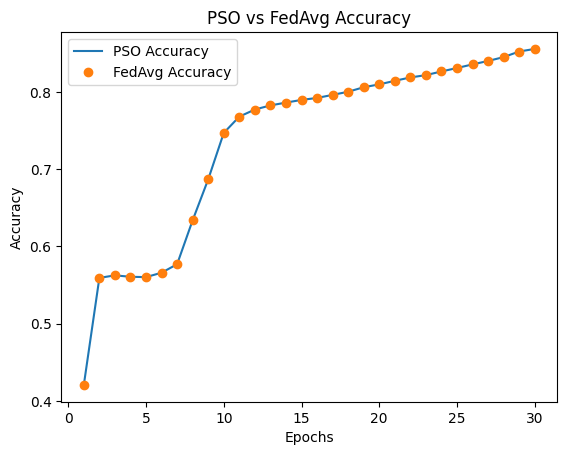

In [36]:
import matplotlib.pyplot as plt

# Plot PSO accuracy
pso_acc = [acc[1] for acc in server_evaluate_acc]  # Assuming server_evaluate_acc contains accuracy values for PSO
plt.plot(range(1, EPOCHS + 1), pso_acc, label='PSO Accuracy', linestyle='-')

# Plot FedAvg accuracy
fedavg_acc = [acc[1] for acc in server_evaluate_acc]  # Assuming server_evaluate_acc contains accuracy values for FedAvg
plt.plot(range(1, EPOCHS + 1), fedavg_acc, label='FedAvg Accuracy', linestyle='', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('PSO vs FedAvg Accuracy')
plt.legend()
plt.show()
